In [4]:
import os
import tempfile
import warnings
from os.path import join as pjoin

import dask
import dask.dataframe as dd
import dask_geopandas as dgpd
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio
from scipy.fft import dst
import tqdm
import xarray as xr
from dask.diagnostics import ProgressBar
from rasterio.crs import CRS

from raster_tools import Raster, Vector, open_vectors, clipping, zonal, warp
from raster_tools.dtypes import F32, U8, U16

import matplotlib.pyplot as plt

# change pandas max col display
pd.set_option('display.max_columns', 500)

# Location for temporary storage
TMP_LOC = "/home/jake/FireLab/Project/data/temp/"
DATA_LOC = "/home/jake/FireLab/Project/data/"

STATE = "OR"

# Location of clipped DEM files
DEM_DATA_DIR = pjoin(TMP_LOC, "dem_data")

# location of feature data files
FEATURE_DIR = pjoin(DATA_LOC, "FeatureData")
EDNA_DIR = pjoin(DATA_LOC, "terrain")
MTBS_DIR = pjoin(DATA_LOC, "MTBS_Data")

mtbs_df_path = pjoin(TMP_LOC, f"{STATE}_mtbs.parquet/")
mtbs_df_parquet_path = pjoin(TMP_LOC, f"{STATE}_mtbs_new.parquet")
mtbs_df_temp_path = pjoin(TMP_LOC, f"{STATE}_mtbs_temp.parquet/")
checkpoint_1_path = pjoin(TMP_LOC, "check1")
checkpoint_2_path = pjoin(TMP_LOC, "check2")

PATHS = {
    "states": pjoin(EDNA_DIR, "state_borders/cb_2018_us_state_5m.shp"),
    "dem": pjoin(EDNA_DIR, "us_orig_dem/us_orig_dem/orig_dem/hdr.adf"),
    "dem_slope": pjoin(EDNA_DIR, "us_slope/us_slope/slope/hdr.adf"),
    "dem_aspect": pjoin(EDNA_DIR, "us_aspect/aspect/hdr.adf"),
    "dem_flow_acc": pjoin(EDNA_DIR, "us_flow_acc/us_flow_acc/flow_acc/hdr.adf"),
    "gm_srad": pjoin(FEATURE_DIR, "gridmet/srad_1986_2020_weekly.nc"),
    "gm_vpd": pjoin(FEATURE_DIR, "gridmet/vpd_1986_2020_weekly.nc"),
    "aw_mat": pjoin(FEATURE_DIR, "adaptwest/Normal_1991_2020_MAT.tif"),
    "aw_mcmt": pjoin(FEATURE_DIR, "adaptwest/Normal_1991_2020_MCMT.tif"),
    "aw_mwmt": pjoin(FEATURE_DIR, "adaptwest/Normal_1991_2020_MWMT.tif"),
    "aw_td": pjoin(FEATURE_DIR, "adaptwest/Normal_1991_2020_TD.tif"),
    "dm_tmax": pjoin(FEATURE_DIR, "daymet/tmax_1986_2020.nc"),
    "dm_tmin": pjoin(FEATURE_DIR, "daymet/tmin_1986_2020.nc"),
    "biomass_afg": pjoin(
        FEATURE_DIR, "biomass/biomass_afg_1986_2020_{}.nc".format(STATE)
    ),
    "biomass_pfg": pjoin(
        FEATURE_DIR, "biomass/biomass_pfg_1986_2020_{}.nc".format(STATE)
    ),
    "landfire_fvt": pjoin(
        FEATURE_DIR, "landfire/LF2020_FVT_200_CONUS/Tif/LC20_FVT_200.tif"
    ),
    "landfire_fbfm40": pjoin(
        FEATURE_DIR, "landfire/LF2020_FBFM40_200_CONUS/Tif/LC20_F40_200.tif"
    ),
    "ndvi": pjoin(FEATURE_DIR, "ndvi/access/weekly/ndvi_1986_2020_weekavg.nc"),
    "mtbs_root": pjoin(MTBS_DIR, "MTBS_BSmosaics/"),
    "mtbs_perim": pjoin(MTBS_DIR, "mtbs_perimeter_data/mtbs_perims_DD.shp"),
}
YEARS = list(range(2016, 2021))
GM_KEYS = list(filter(lambda x: x.startswith("gm_"), PATHS))
AW_KEYS = list(filter(lambda x: x.startswith("aw_"), PATHS))
DM_KEYS = list(filter(lambda x: x.startswith("dm_"), PATHS))
BIOMASS_KEYS = list(filter(lambda x: x.startswith("biomass_"), PATHS))
LANDFIRE_KEYS = list(filter(lambda x: x.startswith("landfire_"), PATHS))
NDVI_KEYS = list(filter(lambda x: x.startswith("ndvi"), PATHS))
DEM_KEYS = list(filter(lambda x: x.startswith("dem"), PATHS))

<Axes: >

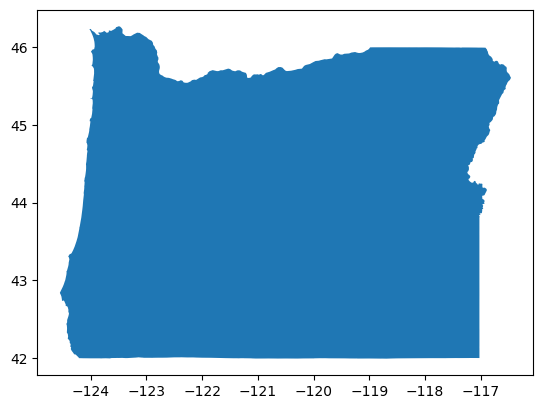

In [5]:
# open the state borders, limit to the state of interest
states = gpd.read_file(PATHS["states"])
state = states[states.STUSPS == STATE]
state.plot()

In [6]:
# now we create functionality to open the DEM data, limit to the state of interest, and combine the data into a single dataframe where each point is a row
# starting with just dem for now
dem = Raster(PATHS["dem"])
dem_clipped = clipping.clip(feature=state, data_raster=dem)

In [12]:
print("Loading state borders")
stdf = open_vectors(PATHS["states"], 0).data.to_crs("EPSG:5071")
states = {st: stdf[stdf.STUSPS == st].geometry for st in list(stdf.STUSPS)}
state_shape = states[STATE]
states = None
stdf = None

Loading state borders


In [13]:
perimdf = open_vectors(PATHS["mtbs_perim"]).data.to_crs("EPSG:5071")

In [37]:
# clip to state
# perimdf = perimdf.clip(state_shape.compute())
perimdf.tail()

,Event_ID,irwinID,Incid_Name,Incid_Type,Map_ID,Map_Prog,Asmnt_Type,BurnBndAc,BurnBndLat,BurnBndLon,Ig_Date,Pre_ID,Post_ID,Perim_ID,dNBR_offst,dNBR_stdDv,NoData_T,IncGreen_T,Low_T,Mod_T,High_T,Comment,geometry
27946,OR4572112013020190713,B799DF0B-AE1F-47F0-BD17-05D52AA76DFF,0461 NORTH GILLIAM SUPPORT,Wildfire,10016329,MTBS,Initial,1274,45.727,-120.148,2019-07-13,804402820180703,804402820190722,None,44,23,-970,-150,55,9999,9999,None,"POLYGON ((-1862714.654 2763907.865, -1862715.8..."
14985,OR4564912052120080703,None,I284,Wildfire,16642,MTBS,Initial,9216,45.649,-120.521,2008-07-03,504502820080628,504502820080714,None,-15,-9999,-970,-150,55,255,490,None,"POLYGON ((-1898616.921 2773765.995, -1898578.8..."
8646,OR4568512039620000927,None,UNNAMED,Unknown,11795,MTBS,Initial,4215,45.685,-120.396,2000-09-27,504402819990917,704402820000927,None,-9,-9999,-970,-150,50,310,9999,None,"MULTIPOLYGON (((-1881285.735 2765180.670, -188..."
8648,OR4576512006420000927,None,UNNAMED,Unknown,11797,MTBS,Initial,8392,45.765,-120.064,2000-09-27,504402819990917,704402820000927,None,7,-9999,-970,-150,100,230,9999,None,"POLYGON ((-1850730.231 2764257.019, -1850698.4..."
26642,OR4576612011120180727,8951B569-0C82-4CCE-8B79-B895C2AE7003,0809 RN,Wildfire,10010420,MTBS,Initial,1550,45.772,-120.08,2018-07-27,804402820180719,804402820180804,None,-25,5,-970,-150,55,9999,9999,None,"POLYGON ((-1855232.482 2766890.808, -1855283.2..."


In [38]:
or_fire = perimdf[perimdf.Event_ID == "OR4564912052120080703"].compute()

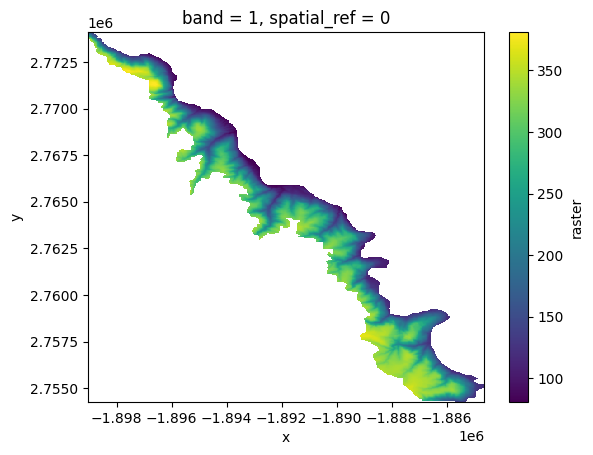

In [43]:
# using the fire perimeter, we can clip the DEM data to the fire perimeter
# this will allow us to calculate the slope and aspect of the fire perimeter

# clip the dem to the fire perimeter
dem_clipped = clipping.clip(feature=or_fire, data_raster=dem)
# plot the clipped dem
dem_clipped.plot()

In [ ]:
# TODO: we must use the perimeter as the base shape, with dem as the base grid
# then, continue to add the other variables to the base grid
# they will need to be reprojeted to the same CRS as the base grid, and the same cell size